In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

from matplotlib.pyplot import figure

## Inputs

In [2]:
TOTAL_IMAGES = 7129
TRAIN_IDXS = [0, 5703]
VALID_IDXS = [5704, 7129]
BATCH_SIZE = 64
NUM_WORKERS=2
SEED=0
LR=0.003

torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
class CustomDataset(Dataset):
    def __init__(self, start_idx = 0, end_idx = 0, path=None, transform=None):
        self.path = path
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.transform = transform
        self.ignore_images=[223,619,624,1093,1804,2778,3105,3128,3251,3255,3321,3379,3416,3664,4014,4462,4467,5825,6045,6241,6307,6699,6940]
    
    def __len__(self):
        return self.end_idx-self.start_idx
    
    def __getitem__(self, idx):
        idx = self.start_idx+idx
        if idx in self.ignore_images:
            idx = self.start_idx
        
        img_gray, img_color = self.load_img(idx)
        
        if self.transform:
            img_gray = self.transform(img_gray)
        
        return img_gray, img_color
    
    def load_img(self, idx):
        img_color = cv2.imread(self.path+"/color/"+str(idx)+".jpg")
        img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        img_color = np.transpose(img_color, (2, 0, 1))
        
        img_gray = cv2.imread(self.path+"/gray/"+str(idx)+".jpg")
        img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
        
        img_gray = img_gray.astype('float32') / 255.0
        img_color = img_color.astype('float32') / 255.0
        
        return img_gray, img_color

In [4]:
my_transforms = transforms.Compose([
   transforms.ToTensor()
])

In [5]:
data_dir = "data/landscape-images"
#data_dir = "/kaggle/input/landscape-image-colorization/landscape Images"
train_set = CustomDataset(path=data_dir, start_idx=TRAIN_IDXS[0], end_idx=TRAIN_IDXS[1], transform=my_transforms)
test_set = CustomDataset(path=data_dir, start_idx=VALID_IDXS[0], end_idx=VALID_IDXS[1], transform=my_transforms)

In [6]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

## Model

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder [N, 1, 150, 150]
        self.e_conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1) # N, 8, 75, 75
        self.e_conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)# N, 16, 38, 38
        self.e_conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)# N, 32, 19, 19
        self.e_conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)# N, 64, 10, 10
        self.e_conv5 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=9, stride=2) # N, 128, 1, 1
        self.e_bc1 = nn.BatchNorm2d(32)
        self.e_bc2 = nn.BatchNorm2d(64)
        self.e_bc3 = nn.BatchNorm2d(128)
        
        #  Decoder [N, 128, 1, 1]
        self.d_conv1 = nn.ConvTranspose2d(512, 128, 9, stride=2, padding=0, output_padding=1) # N, 64 , 10, 10 
        self.d_conv2 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=0) # N, 32 , 19, 19
        self.d_conv3 = nn.ConvTranspose2d(128, 32, 3, stride=2, padding=1, output_padding=1) # N, 16 , 38, 38
        self.d_conv4 = nn.ConvTranspose2d(64, 16, 3, stride=2, padding=1, output_padding=0) # N, 8, 75, 75
        self.d_conv5 = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1) # N, 3, 150, 150
        self.d_out = nn.ConvTranspose2d(4, 3, 1, stride=1, padding=0, output_padding=0) # N, 3, 150, 150
    
    def forward(self, x):
        x_ec1 = F.leaky_relu(self.e_conv1(x), 0.1)
        x_ec2 = self.e_bc1(F.leaky_relu(self.e_conv2(x_ec1), 0.1))
        x_ec3 = self.e_bc2(F.leaky_relu(self.e_conv3(x_ec2), 0.1))
        x_ec4 = self.e_bc3(F.leaky_relu(self.e_conv4(x_ec3), 0.1))
        x_ec5 = F.leaky_relu(self.e_conv5(x_ec4), 0.1)
        
        x_dc1 = F.leaky_relu(self.d_conv1(x_ec5), 0.1)
        x_dc1 = torch.cat((x_dc1, x_ec4), dim=1)
        x_dc2 = F.leaky_relu(self.d_conv2(x_dc1), 0.1)
        x_dc2 = torch.cat((x_dc2, x_ec3), dim=1)
        x_dc3 = F.leaky_relu(self.d_conv3(x_dc2), 0.1)
        x_dc3 = torch.cat((x_dc3, x_ec2), dim=1)
        x_dc4 = F.leaky_relu(self.d_conv4(x_dc3), 0.1)
        x_dc4 = torch.cat((x_dc4, x_ec1), dim=1)
        x_dc5 = F.leaky_relu(self.d_conv5(x_dc4), 0.1)
        x_dc5 = torch.cat((x_dc5, x), dim=1)
        x_out = self.d_out(x_dc5)
        
        return x_out

In [8]:
# timages, tlabels = next(iter(train_loader))

In [9]:
# tnet = AutoEncoder()
# tpred = tnet(timages)
# tpred.shape

In [10]:
#torch.min(timages), torch.max(timages)

In [11]:
#torch.min(tpred), torch.max(tpred)

In [12]:
net = AutoEncoder()
loss = nn.L1Loss() #MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

In [13]:
def train():
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        preds = net(images)
        tloss = loss(preds, labels)
        tloss.backward()
        optimizer.step()
        total_loss += tloss.item()
    
    return total_loss/(TRAIN_IDXS[1]-TRAIN_IDXS[0])

In [14]:
def evalt():
    total_loss = 0
    for images, labels in test_loader:
        preds = net(images)
        tloss = loss(preds, labels)
        total_loss += tloss.item()
    
    return total_loss/(VALID_IDXS[1]-VALID_IDXS[0])

In [15]:
def plot_losses(list1, list2):
    plt.title("Train & Valid Losses")
    plt.plot(list1, label='train')
    plt.plot(list2, label='valid')
    plt.legend()
    plt.show()

6388            Gray                      Color                      Predicted


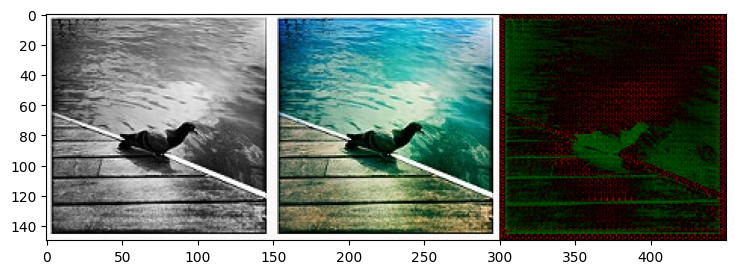

In [16]:
def view_sample_image():
    idx = np.random.randint(VALID_IDXS[0], VALID_IDXS[1])
    img_color = cv2.imread(data_dir+"/color/"+str(idx)+".jpg")
    img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    img_color = img_color.astype('float32') / 255.0
    #img_color = np.transpose(img_color, (2, 0, 1))

    img_gray = cv2.imread(data_dir+"/gray/"+str(idx)+".jpg")
    img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2GRAY)
    img_gray = img_gray.astype('float32') / 255.0
    
    pass_img = torch.unsqueeze(torch.Tensor(img_gray), 0)
    pass_img = torch.unsqueeze(pass_img, 0)
    
    pred_img = net(pass_img)
    pred_img = torch.squeeze(pred_img, 0)
#     print(img_color.shape, pred_img.shape, np.transpose(pred_img, (1, 2, 0)).shape)
#     print("img_color -- min:",torch.min(torch.Tensor(img_color)),  " max:",torch.max(torch.Tensor(img_color)))
#     print("pred_img --- min:",torch.min(torch.Tensor(pred_img)),  " max:",torch.max(torch.Tensor(pred_img)))
#     print("pred_imgT -- min:",torch.min(torch.Tensor(np.transpose(pred_img, (1, 2, 0)))),  " max:",torch.max(torch.Tensor(np.transpose(pred_img, (1, 2, 0)))))
    tmp = np.transpose(np.array([img_gray, img_gray, img_gray]), (1, 2, 0))
    img_stack = np.hstack([tmp, img_color, np.transpose(pred_img, (1, 2, 0))])
#     plt.imshow(img_color)
#     plt.show()
    
#     plt.imshow(img_gray, cmap='gray')
#     plt.show()
    print(idx,10*" ","Gray",20*" ","Color",20*" ","Predicted")
    figure(figsize=(20, 3), dpi=100)
    plt.imshow(img_stack)
    plt.show()
    
with torch.no_grad():
    view_sample_image()

In [17]:
total_train_loss_list = []
total_valid_loss_list = []

Epoch : 0  ... tloss:  0.002903496707748284  vloss:  0.0015260290838124458
Epoch : 1  ... tloss:  0.001313521163402556  vloss:  0.0012293814462527894
Epoch : 2  ... tloss:  0.001141925664579745  vloss:  0.0016450761389314084
Epoch : 3  ... tloss:  0.0010413027360484032  vloss:  0.0011602925940563805
Epoch : 4  ... tloss:  0.000926907760713804  vloss:  0.0009121457631127876
Epoch : 5  ... tloss:  0.0008584444696717611  vloss:  0.000867040052748563
Epoch : 6  ... tloss:  0.000797997069253266  vloss:  0.0008387211200438048
Epoch : 7  ... tloss:  0.0007559845255703837  vloss:  0.000814556069018548
Epoch : 8  ... tloss:  0.0007221633445928124  vloss:  0.0010110147140528025
Epoch : 9  ... tloss:  0.0006673682435978594  vloss:  0.0008236259849447953
Epoch : 10  ... tloss:  0.0006249627147758925  vloss:  0.0007922218347850598
Epoch : 11  ... tloss:  0.0005897918617110827  vloss:  0.0008138752297351234
Epoch : 12  ... tloss:  0.0005519910128115981  vloss:  0.0008390229312997115
Epoch : 13  ... 

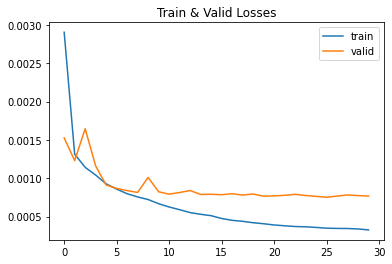

6263            Gray                      Color                      Predicted


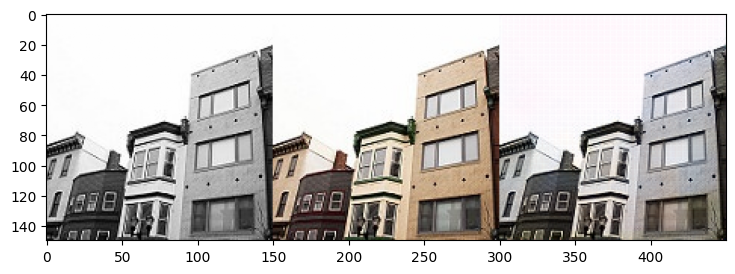

In [18]:
for e in range(30):
    net.train()
    total_train_loss_list.append(train())
    with torch.no_grad():
        net.eval()
        total_valid_loss_list.append(evalt())
    print("Epoch :",e," ... tloss: ",total_train_loss_list[-1]," vloss: ",total_valid_loss_list[-1])

plot_losses(total_train_loss_list, total_valid_loss_list)
with torch.no_grad():
    view_sample_image()

6304            Gray                      Color                      Predicted


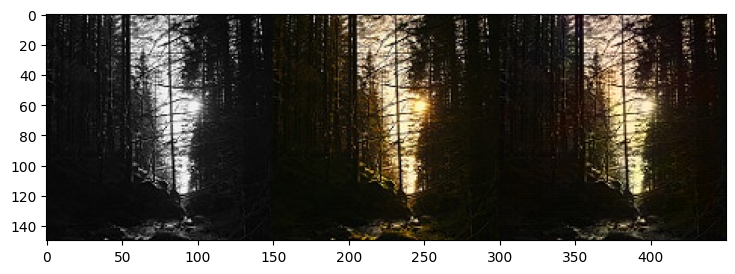

In [29]:
with torch.no_grad():
    view_sample_image()

In [20]:
#model_path = "model-30-epochs-l1-adam-003-lr-kcpu.pth"
#torch.save(net.state_dict(), model_path)